In [1]:
import os
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image, ImageChops, ImageEnhance
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

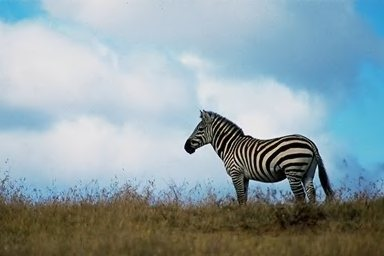

In [3]:
real_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

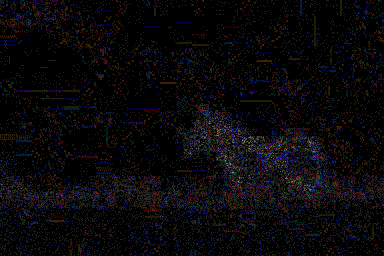

In [4]:
convert_to_ela_image(real_image_path, 95)

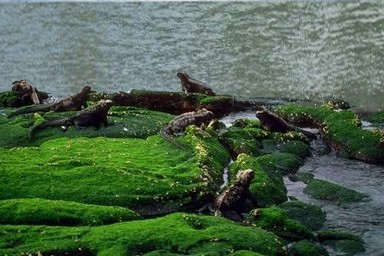

In [5]:
fake_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Image.open(fake_image_path)

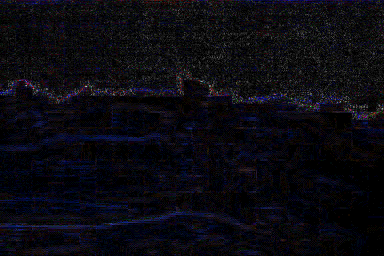

In [6]:
convert_to_ela_image(fake_image_path, 90)

In [7]:
image_size = (128, 128)

In [8]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [9]:
X= []
y = []

In [10]:
import random

path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
print(os.walk(path))
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if filename.lower().endswith(('jpg', 'png')):
            X.append(prepare_image(file_path))
            y.append(1)

random.shuffle(X)

print(len(X), len(y))

<generator object _walk at 0x7bdeb34d8350>
7437 7437


In [11]:
import random
count = 0
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if filename.lower().endswith(('jpg', 'png', 'tif', 'tiff')):
            X.append(prepare_image(file_path))
            y.append(0)


In [12]:
from keras.utils import to_categorical
X = np.array(X)
y = to_categorical(y, 2)
X = X.reshape(-1, 128, 128, 3)

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

10048 10048
2512 2512


In [14]:
base_model= ResNet50(weights='imagenet', include_top=False,input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

94765736/94765736 [==============================] - 0s 0us/step


In [15]:
model2 = Model(inputs=base_model.input, outputs=predictions)

In [16]:
from keras.optimizers import Adam
model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5,mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
history = model2.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping,model_checkpoint]
)


Epoch 1/50
312/314 [============================>.] - ETA: 0s - loss: 0.6811 - accuracy: 0.5834

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 21s 38ms/step - loss: 0.6811 - accuracy: 0.5833 - val_loss: 0.6439 - val_accuracy: 0.6158
Epoch 2/50
314/314 [==============================] - 10s 31ms/step - loss: 0.6356 - accuracy: 0.6248 - val_loss: 0.5802 - val_accuracy: 0.7034
Epoch 3/50
314/314 [==============================] - 9s 29ms/step - loss: 0.5838 - accuracy: 0.6878 - val_loss: 0.5573 - val_accuracy: 0.6425
Epoch 4/50
314/314 [==============================] - 10s 31ms/step - loss: 0.5376 - accuracy: 0.7265 - val_loss: 0.5334 - val_accuracy: 0.7564
Epoch 5/50
314/314 [==============================] - 9s 29ms/step - loss: 0.5224 - accuracy: 0.7345 - val_loss: 0.5288 - val_accuracy: 0.7014
Epoch 6/50
314/314 [==============================] - 10s 30ms/step - loss: 0.5042 - accuracy: 0.7509 - val_loss: 0.4751 - val_accuracy: 0.7576
Epoch 7/50
314/314 [==============================] - 9s 28ms/step - loss: 0.5056 - accuracy: 0.7497 - val_loss: 0.4843 - val_accuracy: 0.7464
Epoch 

In [17]:
model2.evaluate(X_val,Y_val)

79/79 [==============================] - 2s 24ms/step - loss: 0.4547 - accuracy: 0.7954


[0.4547121524810791, 0.7953821420669556]

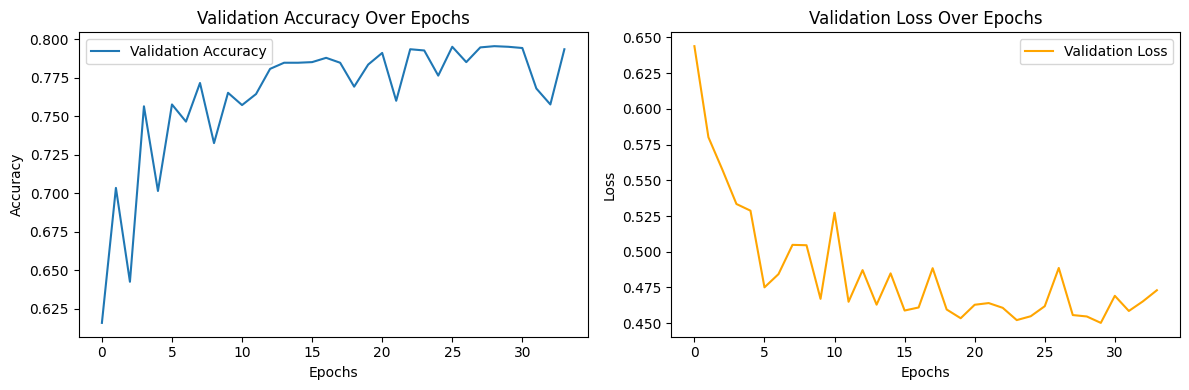

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

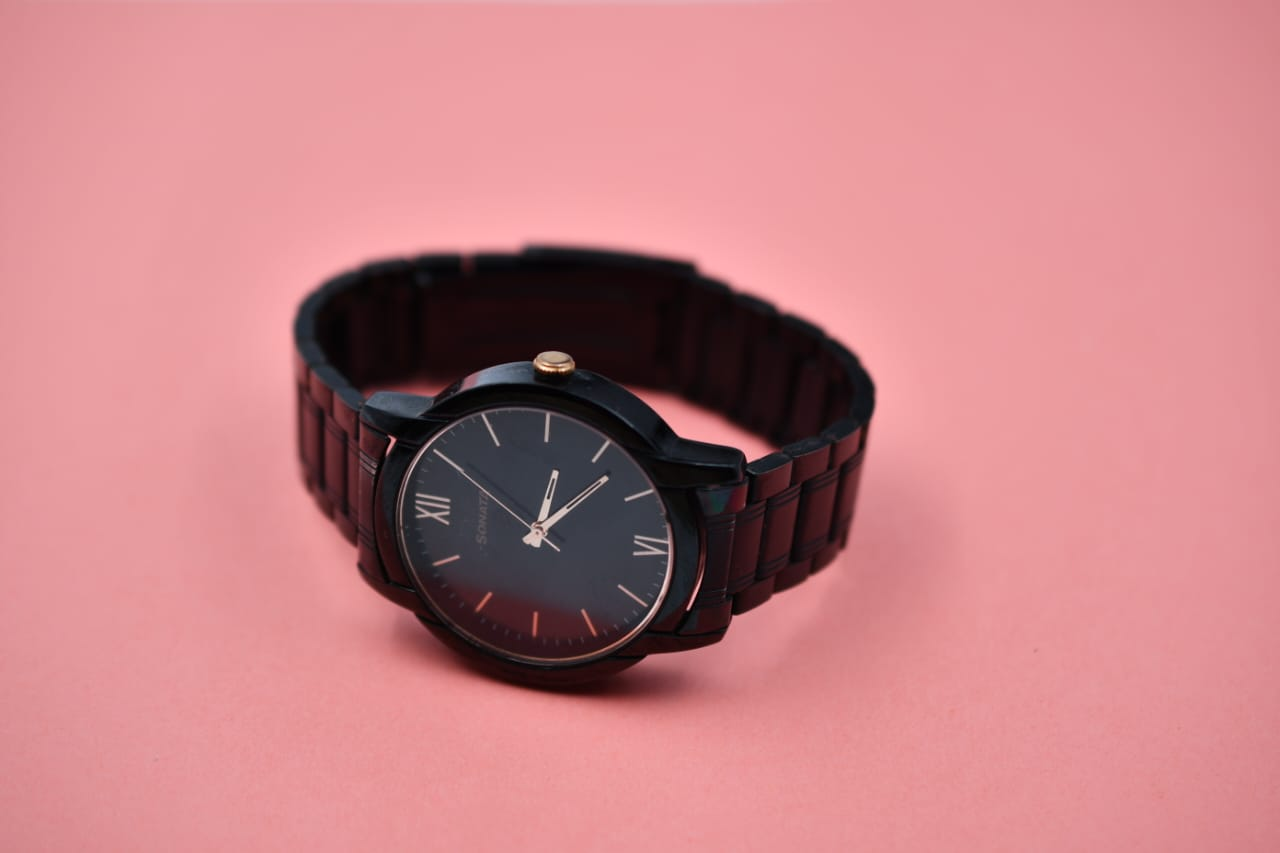

In [29]:
real_image_path1 = '/kaggle/input/realtime2/f2.jpg'
Image.open(real_image_path1)

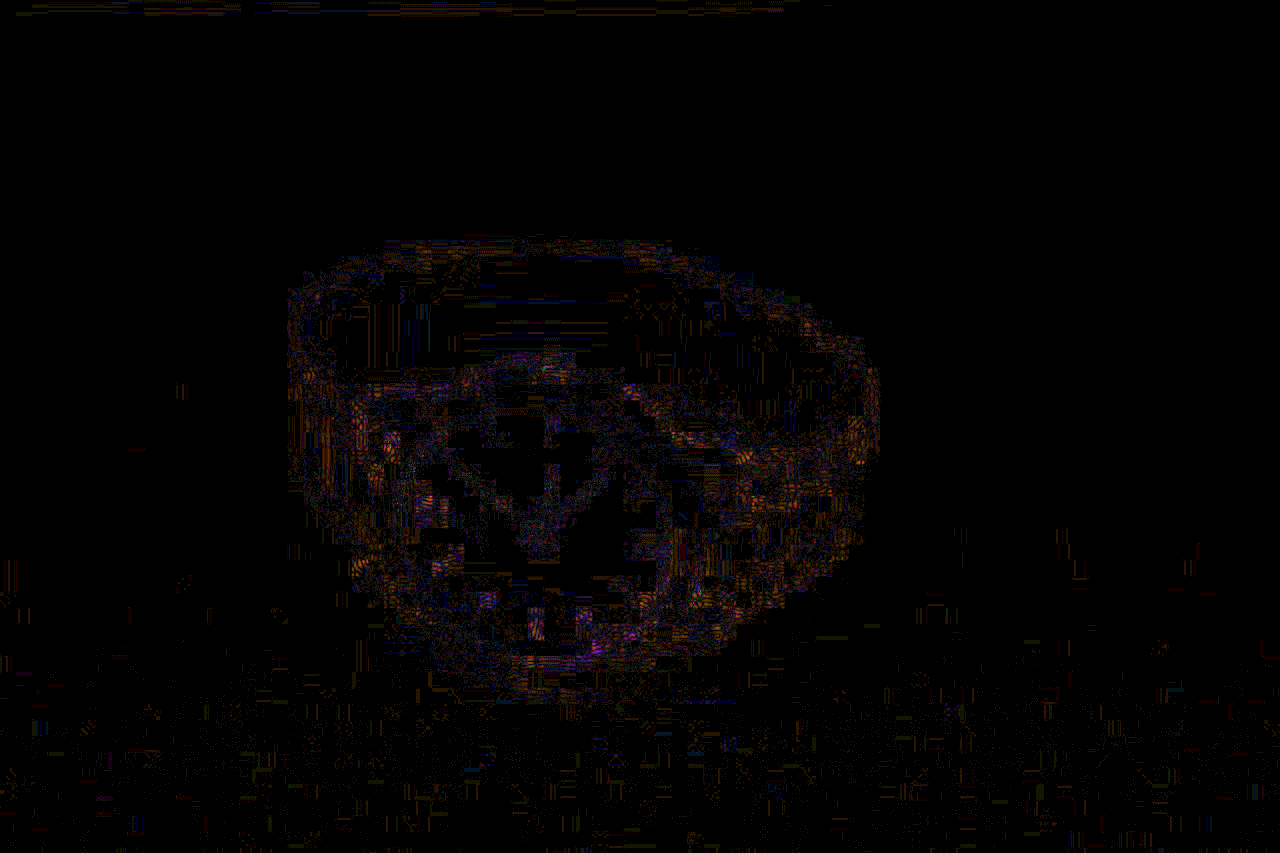

In [30]:
convert_to_ela_image(real_image_path1, 90)

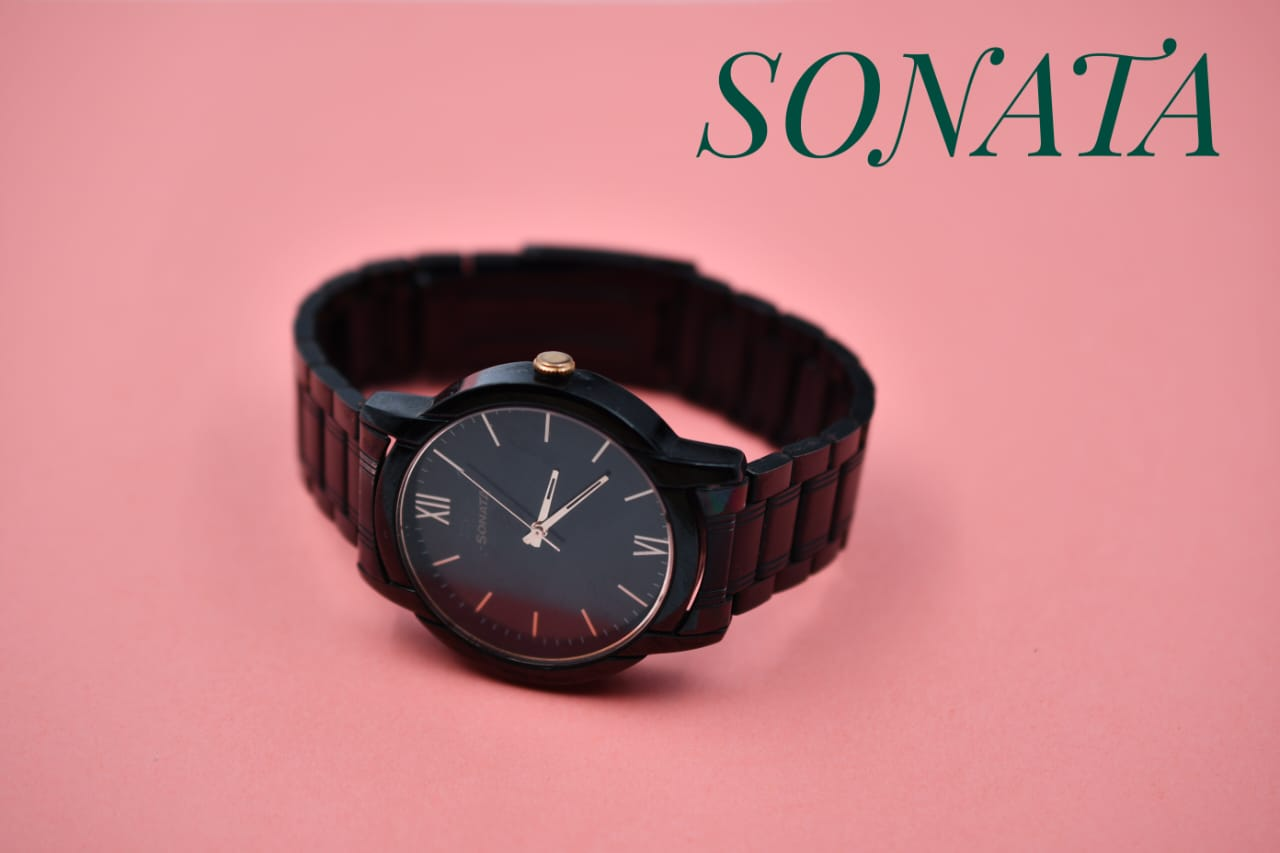

In [27]:
fake_image_path1 = '/kaggle/input/realtime2/f1.jpg'
Image.open(fake_image_path1)

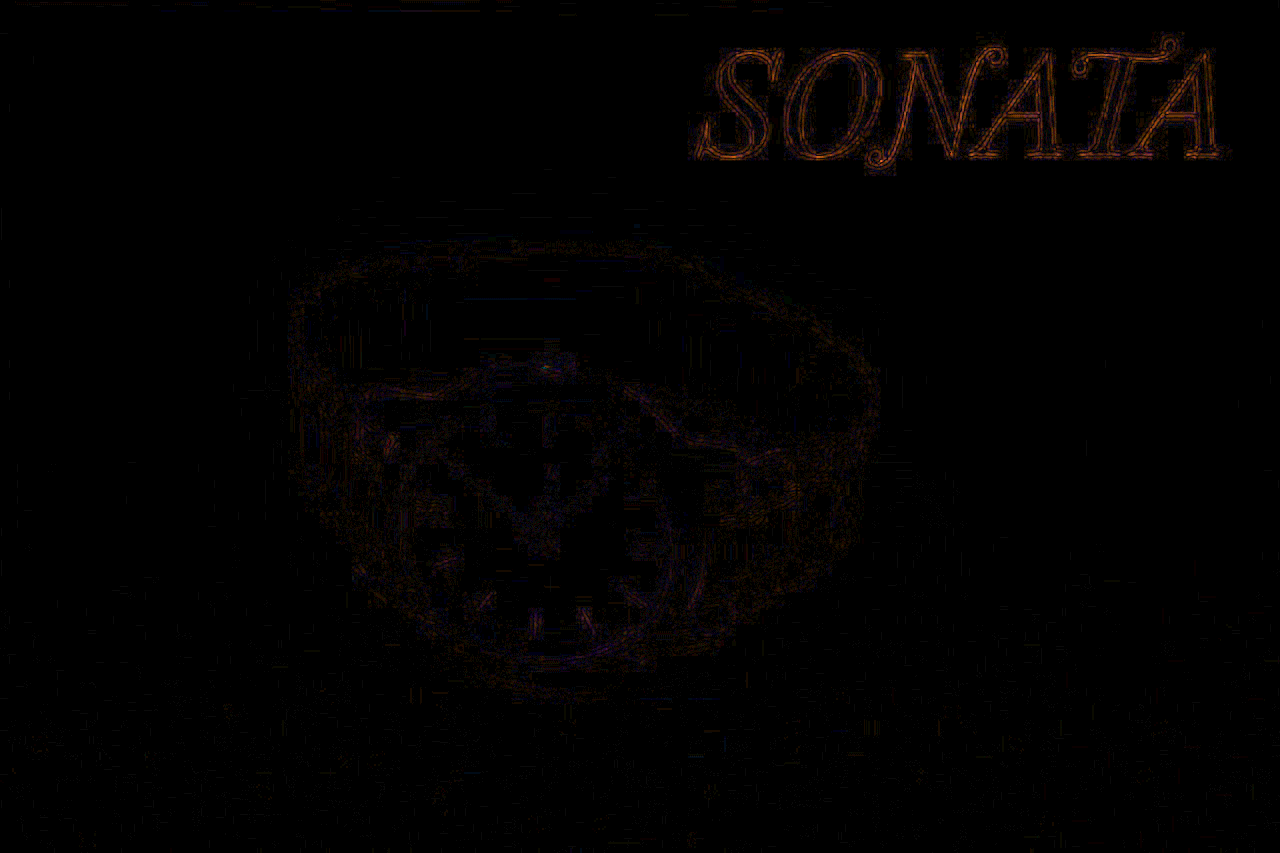

In [28]:
convert_to_ela_image(fake_image_path1, 95)